# 重新读入数据，使用GBDT

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.sparse as sp
from sklearn.utils import check_random_state 
import pylab 
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fea0_1=pd.read_csv('~/10w_train_count_day_hash.csv')
fea1_1=pd.read_csv('~/test_count_day_hash.csv')

# 准备数据

catNum=['site_id','site_domain','site_category','app_id','app_domain',
        'app_category','device_id','device_ip','device_model','C17','C19',
        'C20','C21','hour_day','device_id_count','device_ip_count','user_count']

In [ ]:
X_train=fea0_1
y_train=fea0_1['click']

In [6]:
# 训练样本50w+，先使用交叉验证，再用train_test_split估计模型性能
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.8,random_state = 0)

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# 1. 直接调用xgboost内嵌的cv寻找最佳的参数n_estimators

In [7]:
# prepare cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
import xgboost as xgb
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [8]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def modelfit(alg, X_train, y_train, cv_folds=5, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    #xgb_param['num_class'] = 2
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='logloss', early_stopping_rounds=early_stopping_rounds)
  
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='logloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)
    #Predict training set
    #Print model report:
    print ("logloss of train :" )
    print (logloss)

In [9]:
#先寻找最佳的树个数，n_estimators=157
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 9}
xgb1 = XGBClassifier(
        learning_rate =0.05,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators  
        max_depth=5,
        min_child_weight=5,
        gamma=0,
        subsample = 0.85,
        colsample_bytree=0.7,
        colsample_bylevel=0.9,
        reg_alpha = 2.5,
        reg_lambda= 0.5,
        objective= 'binary:logistic',
        seed=3)
# 训练数据：X_train_part, y_train_part   验证数据：X_val, y_val
modelfit(xgb1, X_train, y_train)

logloss of train :
0.38999714410736386


第一轮：logloss of train :
0.38627035965123563
第二轮：logloss of train :
0.3859769922715946
第三轮：logloss of train :
0.38219099945632534


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 1431,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 2.5,
 'reg_lambda': 0.5,
 'scale_pos_weight': 1,
 'seed': 3,
 'silent': 1,
 'subsample': 0.85}

In [10]:
xgb1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.9,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 502,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 2.5,
 'reg_lambda': 0.5,
 'scale_pos_weight': 1,
 'seed': 3,
 'silent': 1,
 'subsample': 0.85}

/home/fuxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


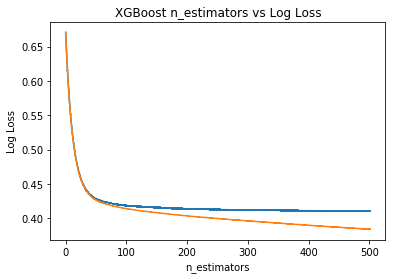

In [111]:
import matplotlib.pyplot as pyplot
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')
        
# plot
test_means = cvresult['test-logloss-mean']
test_stds = cvresult['test-logloss-std'] 
        
train_means = cvresult['train-logloss-mean']
train_stds = cvresult['train-logloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators4_1.png' )

pyplot.show()

/home/fuxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


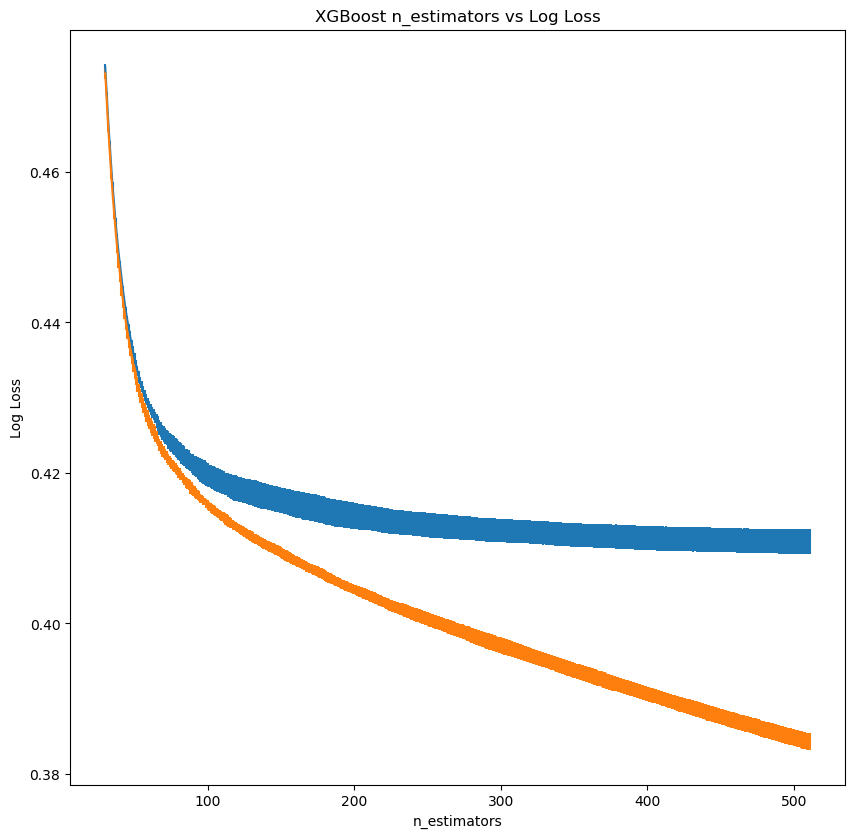

In [112]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')

cvresult = cvresult.iloc[20:]
# plot
test_means = cvresult['test-logloss-mean']
test_stds = cvresult['test-logloss-std'] 
        
train_means = cvresult['train-logloss-mean']
train_stds = cvresult['train-logloss-std'] 

x_axis = range(30,cvresult.shape[0]+30)
        
fig = pyplot.figure(figsize=(10, 10), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail.png' )

pyplot.show()

In [114]:
#验证数据：X_val, y_val
#train_predprob = xgb1.predict_proba(X_val)
#logloss = log_loss(y_val, train_predprob)
#Print model report:
#print ('logloss of validation is:', logloss)

第一轮：logloss of validation is: 0.41698918235700383
第二轮：logloss of validation is: 0.4204885146566607

In [113]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
y_prob = xgb1.predict_proba(X_train)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
xgb1.score(X_train, y_pred)
auc_roc=roc_auc_score(y_train,y_pred)   #算得分
auc_roc

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5278253894150391

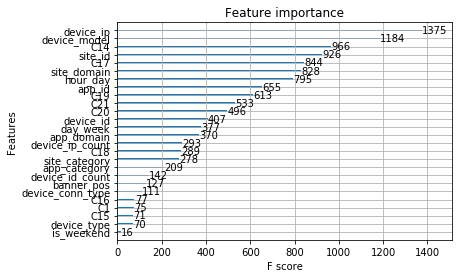

In [11]:
from xgboost import plot_importance
plot_importance(xgb1)
plt.show()

In [12]:
xgb1.feature_importances_

array([0.00618455, 0.0104725 , 0.07635854, 0.0682774 , 0.02292405,
       0.05401171, 0.03051043, 0.01723427, 0.03356148, 0.11338336,
       0.09763338, 0.00577224, 0.00915313, 0.07965697, 0.0058547 ,
       0.00634947, 0.06959677, 0.02383112, 0.05054836, 0.04090047,
       0.04395151, 0.01170941, 0.02416096, 0.03108766, 0.0655562 ,
       0.00131937], dtype=float32)

In [119]:
new_X_train = X_train.ix[:,xgb1.feature_importances_>0]
#new_X_val = X_val.ix[:,xgb1.feature_importances_>0]

In [13]:
#new_X_train.head()
xgb_train=xgb1.apply(X_train)

In [126]:
xgb_train

array([[27, 38, 34, ..., 30, 29, 49],
       [33, 40, 34, ..., 31, 29, 49],
       [34, 38, 34, ..., 34, 26, 37],
       ...,
       [33, 40, 34, ..., 31, 29, 40],
       [33, 39, 34, ..., 24, 31, 37],
       [27, 43, 34, ..., 31, 25, 40]], dtype=int32)

In [14]:
#调用one-hot编码
from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
#调用LR分类模型
#使用X_train训练GBDT模型，后面用此模型构造特征
#fit one-hot编码器
lr_train=oneHot.fit_transform(xgb_train)
#使用训练好的GBDT模型构建特征，然后将特征经过one-hot编码作为新的特征输入到LR模型训练。

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
#tuned_parameters = {'penalty':['l1','l2'],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5, scoring='neg_log_loss')
grid.fit(lr_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [16]:
# examine the best model
print(-grid.best_score_)
print(grid.best_params_)

0.40643473170565136
{'C': 0.001, 'penalty': 'l2'}


In [ ]:
#保存模型
import pickle
pickle.dump(xgb1, open("xgb_model.pkl", 'wb'))
#测试模型
import pickle
xgb = pickle.load(open("xgb_model.pkl", 'rb'))
train_predprob = xgb.predict_proba(X_train)
logloss = log_loss(y_train, train_predprob)
#Print model report:
print ('logloss of train is:', logloss)
#logloss of train is: 0.38721551918830166


# 第二步：调整树的参数：max_depth & min_child_weight

(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)


In [161]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [162]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [165]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=157,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'binary:logistic',
        seed=3)


gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train , y_train)

gsearch2_1.grid_scores_, gsearch2_1.best_params_,     gsearch2_1.best_score_

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: Deprecat

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: Deprecat

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: Deprecat

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: Deprecat

([mean: -0.41655, std: 0.00074, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.41661, std: 0.00072, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.41673, std: 0.00096, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.41281, std: 0.00094, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.41300, std: 0.00106, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.41272, std: 0.00106, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.41447, std: 0.00069, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.41355, std: 0.00150, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.41354, std: 0.00130, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.41908, std: 0.00137, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.41743, std: 0.00125, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.41631, std: 0.00185, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

In [166]:
gsearch2_1.cv_results_

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site

{'mean_fit_time': array([15.37328806, 15.33458295, 15.34409237, 24.39013324, 24.29803681,
        24.31313148, 33.92179732, 33.48471403, 34.02185998, 43.62611227,
        42.19443769, 30.05446916]),
 'mean_score_time': array([0.18566036, 0.16080389, 0.15374179, 0.25138102, 0.25084548,
        0.24891911, 0.34640536, 0.33312044, 0.33323913, 0.5237967 ,
        0.45661879, 0.30088196]),
 'mean_test_score': array([-0.41655273, -0.41661096, -0.41672532, -0.41281379, -0.41299686,
        -0.41271622, -0.41446548, -0.41355304, -0.41354167, -0.41908043,
        -0.41743346, -0.41631144]),
 'mean_train_score': array([-0.41133546, -0.41173183, -0.4118581 , -0.39589014, -0.39778123,
        -0.39860189, -0.37209336, -0.37821524, -0.38211033, -0.3401377 ,
        -0.35512619, -0.36297378]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        

Best: -0.412716 using {'max_depth': 5, 'min_child_weight': 5}


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-pa

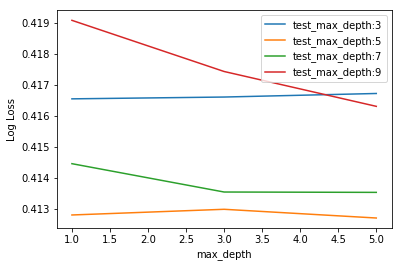

In [167]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    pyplot.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

# 第二步：调整树的参数：max_depth & min_child_weight

(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)


In [175]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = [4,5,6]
min_child_weight = [4,5,6]
param_test2_2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_2

{'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]}

In [176]:
xgb2_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=157,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'binary:logistic',
        seed=3)


gsearch2_2 = GridSearchCV(xgb2_2, param_grid = param_test2_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_2.fit(X_train , y_train)

gsearch2_2.grid_scores_, gsearch2_2.best_params_,     gsearch2_2.best_score_

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.41445, std: 0.00090, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.41456, std: 0.00084, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.41445, std: 0.00077, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.41304, std: 0.00109, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -0.41272, std: 0.00106, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.41321, std: 0.00096, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.41273, std: 0.00057, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.41292, std: 0.00066, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.41276, std: 0.00096, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 5, 'min_child_weight': 5},
 -0.41271621624977284)

In [177]:
gsearch2_2.cv_results_

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site

{'mean_fit_time': array([19.87262383, 20.36924291, 19.60885825, 23.91988721, 23.78038845,
        23.90305142, 28.72446222, 29.45523968, 21.96872802]),
 'mean_score_time': array([0.21951156, 0.21292176, 0.19179435, 0.23661871, 0.24435334,
        0.24145265, 0.31237526, 0.3039144 , 0.20895028]),
 'mean_test_score': array([-0.41444511, -0.41455527, -0.41444604, -0.41304358, -0.41271622,
        -0.41320813, -0.4127345 , -0.41291772, -0.41275539]),
 'mean_train_score': array([-0.40539094, -0.4055926 , -0.40572768, -0.39819506, -0.39860189,
        -0.39903224, -0.38946582, -0.39067843, -0.39154701]),
 'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
              mask=[False, False, False, False, False, False, False, False,
                    F

Best: -0.412716 using {'max_depth': 5, 'min_child_weight': 5}


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-pa

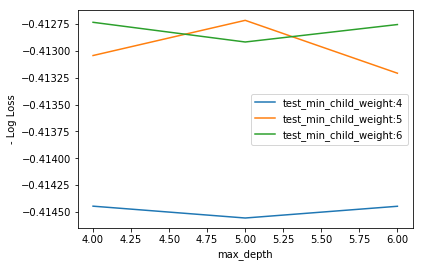

In [179]:
# summarize results
print("Best: %f using %s" % (gsearch2_2.best_score_, gsearch2_2.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(min_child_weight), len(max_depth))
train_scores = np.array(train_means).reshape(len(min_child_weight), len(max_depth))

for i, value in enumerate(min_child_weight):
    pyplot.plot(max_depth, test_scores[i], label= 'test_min_child_weight:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( '- Log Loss' )
pyplot.savefig( 'max_depth_vs_min_child_weght2.png' )

# 再次调整弱分类器数目

In [180]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [181]:
def modelfit_1(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        #xgb_param['num_class'] = 9
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
                         metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print (cvresult)
        #result = pd.DataFrame(cvresult)   #cv缺省返回结果为DataFrame
        #result.to_csv('my_preds.csv', index_label = 'n_estimators')
        cvresult.to_csv('2_my_preds4_2_3_157.csv', index_label = 'n_estimators')
        
        # plot
        test_means = cvresult['test-logloss-mean']
        test_stds = cvresult['test-logloss-std'] 
        
        train_means = cvresult['train-logloss-mean']
        train_stds = cvresult['train-logloss-std'] 

        x_axis = range(0, n_estimators)
        pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
        pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
        pyplot.title("XGBoost 2_n_estimators vs Log Loss")
        pyplot.xlabel( 'n_estimators' )
        pyplot.ylabel( 'Log Loss' )
        pyplot.savefig( '2_n_estimators.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='logloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

        
    #Print model report:
    print ("logloss of train :" )
    print (logloss)

     test-logloss-mean  test-logloss-std  train-logloss-mean  \
0             0.649447          0.000265            0.649347   
1             0.613757          0.000351            0.613525   
2             0.584080          0.000318            0.583769   
3             0.559607          0.000171            0.559231   
4             0.539112          0.000199            0.538632   
5             0.521941          0.000237            0.521371   
6             0.507475          0.000450            0.506836   
7             0.495489          0.000355            0.494743   
8             0.484629          0.000170            0.483735   
9             0.475755          0.000238            0.474745   
10            0.467996          0.000415            0.466888   
11            0.461611          0.000564            0.460420   
12            0.456153          0.000697            0.454893   
13            0.451616          0.000776            0.450281   
14            0.447550          0.000769

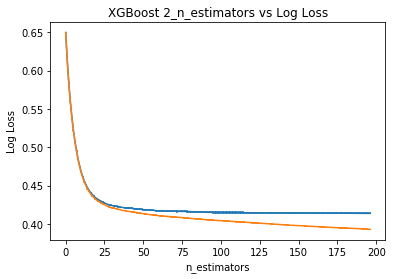

In [184]:
#调整max_depth和min_child_weight之后再次调整n_estimators(6,4)
xgb2_3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=5,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'binary:logistic',
        seed=3)

modelfit_1(xgb2_3, X_train, y_train, cv_folds = kfold)
#from sklearn.model_selection import cross_val_score
#results = cross_val_score(xgb2_3, X_train, y_train, metrics='mlogloss', cv=kfold)
#print results
#print("CV logloss: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [185]:
xgb2_3.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 197,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 3,
 'silent': 1,
 'subsample': 0.3}

# 'n_estimators': 197,

/home/fuxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


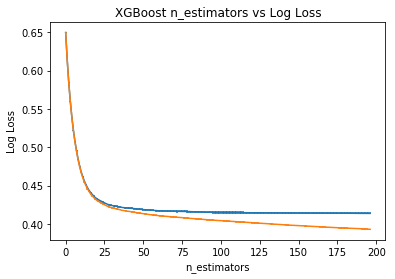

In [189]:
import matplotlib.pyplot as pyplot
cvresult = pd.DataFrame.from_csv('2_my_preds4_2_3_157.csv')
        
# plot
test_means = cvresult['test-logloss-mean']
test_stds = cvresult['test-logloss-std'] 
        
train_means = cvresult['train-logloss-mean']
train_stds = cvresult['train-logloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( '2_n_estimators4_1.png' )

pyplot.show()

/home/fuxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


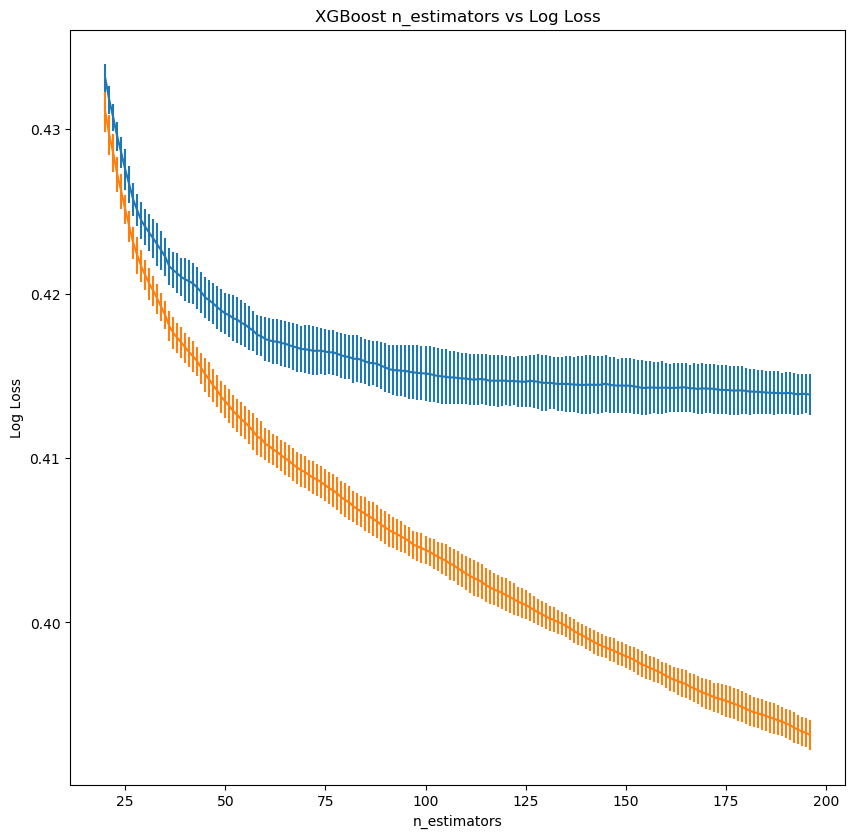

In [190]:
cvresult = pd.DataFrame.from_csv('2_my_preds4_2_3_157.csv')

cvresult = cvresult.iloc[20:]
# plot
test_means = cvresult['test-logloss-mean']
test_stds = cvresult['test-logloss-std'] 
        
train_means = cvresult['train-logloss-mean']
train_stds = cvresult['train-logloss-std'] 

x_axis = range(20,cvresult.shape[0]+20)
        
fig = pyplot.figure(figsize=(10, 10), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail4_2_3_157.png' )

pyplot.show()

# 第四步：调整树的参数：subsample 和 colsample_bytree

(粗调，参数的步长为0.1；下一步是在粗调最佳参数周围，将步长降为0.05，进行精细调整)


In [195]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
#subsample = [i/10.0 for i in range(3,9)]
subsample=[0.8,0.85,0.9]
#colsample_bytree = [i/10.0 for i in range(6,10)]
colsample_bytree=[0.85,0.9,0.95]
param_test3_1 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test3_1


{'colsample_bytree': [0.85, 0.9, 0.95], 'subsample': [0.8, 0.85, 0.9]}

In [196]:
xgb3_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=197,  #第二轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=5,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'binary:logistic',
        seed=3)


gsearch3_1 = GridSearchCV(xgb3_1, param_grid = param_test3_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3_1.fit(X_train , y_train)

gsearch3_1.grid_scores_, gsearch3_1.best_params_,     gsearch3_1.best_score_

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.41020, std: 0.00087, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: -0.41018, std: 0.00118, params: {'colsample_bytree': 0.85, 'subsample': 0.85},
  mean: -0.41026, std: 0.00096, params: {'colsample_bytree': 0.85, 'subsample': 0.9},
  mean: -0.41009, std: 0.00089, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
  mean: -0.41001, std: 0.00085, params: {'colsample_bytree': 0.9, 'subsample': 0.85},
  mean: -0.41008, std: 0.00097, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: -0.41025, std: 0.00106, params: {'colsample_bytree': 0.95, 'subsample': 0.8},
  mean: -0.41034, std: 0.00105, params: {'colsample_bytree': 0.95, 'subsample': 0.85},
  mean: -0.41008, std: 0.00089, params: {'colsample_bytree': 0.95, 'subsample': 0.9}],
 {'colsample_bytree': 0.9, 'subsample': 0.85},
 -0.4100096852657063)

In [197]:
gsearch3_1.cv_results_

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site

{'mean_fit_time': array([31.38595815, 30.78249435, 30.95299039, 32.2982502 , 31.75257039,
        31.31025033, 31.86353602, 32.37392168, 19.20862069]),
 'mean_score_time': array([0.31081924, 0.29645967, 0.29950747, 0.29876032, 0.29956131,
        0.29267101, 0.27837057, 0.28075991, 0.15971313]),
 'mean_test_score': array([-0.41019856, -0.41017659, -0.41025983, -0.41009348, -0.41000969,
        -0.41007913, -0.41024977, -0.41034071, -0.41007888]),
 'mean_train_score': array([-0.39098362, -0.3905873 , -0.39089249, -0.39039233, -0.39046773,
        -0.39052166, -0.39048985, -0.39064809, -0.39057688]),
 'param_colsample_bytree': masked_array(data=[0.85, 0.85, 0.85, 0.9, 0.9, 0.9, 0.95, 0.95, 0.95],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.8, 0.85, 0.9, 0.8, 0.85, 0.9, 0.8, 0.85, 0.9],
              mask=[False, False, False, False, Fals

Best: -0.410010 using {'colsample_bytree': 0.9, 'subsample': 0.85}


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-pa

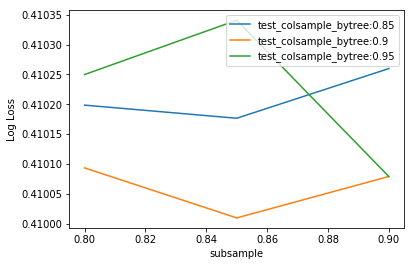

In [198]:
# summarize results
print("Best: %f using %s" % (gsearch3_1.best_score_, gsearch3_1.best_params_))
test_means = gsearch3_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch3_1.cv_results_[ 'std_test_score' ]
train_means = gsearch3_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch3_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch3_1.cv_results_).to_csv('my_preds_subsampleh_colsample_bytree_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

for i, value in enumerate(colsample_bytree):
    pyplot.plot(subsample, -test_scores[i], label= 'test_colsample_bytree:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'subsample' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'subsample_vs_colsample_bytree1.png' )

# 第五步：调整正则化参数：reg_alpha 和reg_lambda


In [201]:
#reg_alpha = [1e-3, 1e-2, 0.05, 0.1]    #default = 0
#reg_lambda = [1e-3, 1e-2, 0.05, 0.1]   #default = 1

reg_alpha = [ 1,1.5, 2,2.5,3]    #default = 0, 测试0.1,1，1.5，2
reg_lambda = [0.05,0.1,0.5, 1.5,2]      #default = 1，测试0.1， 0.5， 1，2

param_test5_1 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test5_1


{'reg_alpha': [1, 1.5, 2, 2.5, 3], 'reg_lambda': [0.05, 0.1, 0.5, 1.5, 2]}

In [202]:
xgb5_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=197,  #第二轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=5,
        gamma=0,
        subsample=0.85,
        colsample_bytree=0.9,
        colsample_bylevel = 0.7,
        objective= 'binary:logistic',
        seed=3)


gsearch5_1 = GridSearchCV(xgb5_1, param_grid = param_test5_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch5_1.fit(X_train , y_train)

gsearch5_1.grid_scores_, gsearch5_1.best_params_,     gsearch5_1.best_score_

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.40993, std: 0.00092, params: {'reg_alpha': 1, 'reg_lambda': 0.05},
  mean: -0.40996, std: 0.00103, params: {'reg_alpha': 1, 'reg_lambda': 0.1},
  mean: -0.40983, std: 0.00094, params: {'reg_alpha': 1, 'reg_lambda': 0.5},
  mean: -0.41023, std: 0.00102, params: {'reg_alpha': 1, 'reg_lambda': 1.5},
  mean: -0.41014, std: 0.00099, params: {'reg_alpha': 1, 'reg_lambda': 2},
  mean: -0.41010, std: 0.00105, params: {'reg_alpha': 1.5, 'reg_lambda': 0.05},
  mean: -0.40989, std: 0.00066, params: {'reg_alpha': 1.5, 'reg_lambda': 0.1},
  mean: -0.41022, std: 0.00079, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.40995, std: 0.00093, params: {'reg_alpha': 1.5, 'reg_lambda': 1.5},
  mean: -0.41008, std: 0.00106, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.41011, std: 0.00088, params: {'reg_alpha': 2, 'reg_lambda': 0.05},
  mean: -0.41004, std: 0.00098, params: {'reg_alpha': 2, 'reg_lambda': 0.1},
  mean: -0.40978, std: 0.00087, params: {'reg_alpha': 2, 'reg_lambd

In [203]:
gsearch5_1.cv_results_

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site

{'mean_fit_time': array([32.49238567, 32.10237594, 32.14324098, 31.62502937, 31.70541468,
        31.6589541 , 31.41028523, 31.33510513, 31.47901974, 31.60633245,
        32.62688518, 31.6011342 , 31.80557094, 31.35113654, 31.30304947,
        31.71845264, 31.30195632, 31.56543612, 31.49913812, 31.44211798,
        31.74451451, 31.02363191, 31.58112435, 31.46695042, 20.50541558]),
 'mean_score_time': array([0.29644771, 0.29300723, 0.29376807, 0.28808141, 0.28662629,
        0.29287291, 0.2907167 , 0.28561502, 0.28618374, 0.28257909,
        0.28759279, 0.28764853, 0.28901243, 0.28388424, 0.28529048,
        0.2939507 , 0.28938012, 0.2916069 , 0.28302379, 0.28229995,
        0.29080091, 0.28316908, 0.28471856, 0.28644691, 0.16672559]),
 'mean_test_score': array([-0.40993333, -0.40996296, -0.40982565, -0.41022766, -0.410144  ,
        -0.41009987, -0.40989046, -0.41021637, -0.40995242, -0.41008164,
        -0.41010735, -0.41003581, -0.40978279, -0.41015017, -0.40996524,
        -0.410029

Best: -0.409728 using {'reg_alpha': 2.5, 'reg_lambda': 0.5}


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/fuxi/anaconda3/lib/python3.6/site-pa

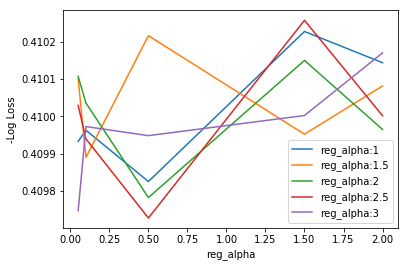

In [204]:
# summarize results
print("Best: %f using %s" % (gsearch5_1.best_score_, gsearch5_1.best_params_))
test_means = gsearch5_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch5_1.cv_results_[ 'std_test_score' ]
train_means = gsearch5_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch5_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch5_1.cv_results_).to_csv('my_preds_reg_alpha_reg_lambda_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))

#log_reg_alpha = [0,0,0,0]
#for index in range(len(reg_alpha)):
#   log_reg_alpha[index] = math.log10(reg_alpha[index])
    
for i, value in enumerate(reg_alpha):
    pyplot.plot(reg_lambda, -test_scores[i], label= 'reg_alpha:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'reg_alpha' )                                                                                                      
pyplot.ylabel( '-Log Loss' )
pyplot.savefig( 'reg_alpha_vs_reg_lambda1.png' )

# 6. 调整学习率，再次直接调用xgboost内嵌的cv寻找最佳的参数n_estimators

In [17]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def modelfit_2(alg, X_train, y_train, cv_folds=3, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    #xgb_param['num_class'] = 3
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='logloss', early_stopping_rounds=early_stopping_rounds)
  
    cvresult.to_csv('6_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='logloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

   #Print model report:
    print ('logloss of train is:', logloss)

In [18]:
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 9}
xgb6 = XGBClassifier(
        learning_rate =0.05,
        n_estimators=2000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=5,
        gamma=0,
        subsample = 0.85,
        colsample_bytree=0.9,
        colsample_bylevel=0.7,
        reg_alpha = 2.5,  #叶子结点数目   ，越大越好
        reg_lambda = 0.5,  #叶子结点分数，越小越好
        objective= 'binary:logistic',
        seed=3)

modelfit_2(xgb6, X_train, y_train)

logloss of train is: 0.38725263886334504


In [19]:
xgb6.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 1431,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 2.5,
 'reg_lambda': 0.5,
 'scale_pos_weight': 1,
 'seed': 3,
 'silent': 1,
 'subsample': 0.85}

# 保存模型，供测试使用

In [20]:
#保存模型
import pickle
pickle.dump(xgb6, open("xgb_model.pkl", 'wb'))

In [217]:
#保存数据
import pickle

xgb = pickle.load(open("xgb_model.pkl", 'rb'))

train_predprob = xgb.predict_proba(X_train)
logloss = log_loss(y_train, train_predprob)

#Print model report:
print ('logloss of train is:', logloss)

logloss of train is: 0.38721551918830166
